[Link to Page](https://tutorials.pytorch.kr/beginner/nn_tutorial.html)

# Load MNIST

In [1]:
import pickle, gzip

with gzip.open('C:/Users/OWNER/Desktop/mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


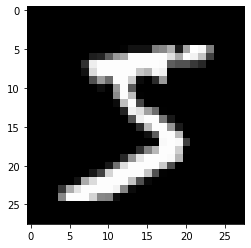

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28,28)), cmap = 'gray')
print(x_train.shape)

In [3]:
import torch
# numpy --> tensor mapping
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape


#print(x_train, y_train)
print(x_train.shape) # size : 50000, 28*28
print(y_train.shape) # 0~9 : one-hot xxx
print(y_train.min().item(), y_train.max().item())

torch.Size([50000, 784])
torch.Size([50000])
0 9


# Without torch.nn

In [4]:
# weight & bias
weights = torch.randn(x_train.shape[1], 10) / np.sqrt(x_train.shape[1]) # Xaiver Initialization
weights.requires_grad_() # going to update 
bias = torch.zeros(10, requires_grad = True)

In [5]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias) # @ : dot product

In [6]:
batch_size = 64

x_batch = x_train[0:batch_size]
preds = model(x_batch)
print(preds[0])
print(preds.shape)

tensor([-2.2242, -2.0906, -2.7354, -2.0834, -2.0492, -2.2806, -3.4777, -2.1436,
        -2.2042, -2.4152], grad_fn=<SelectBackward>)
torch.Size([64, 10])


In [7]:
# Negative log-likelihood ( NLL ) --> Loss
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [8]:
y_batch = y_train[0:batch_size]
print(loss_func(preds, y_batch))

tensor(2.4024, grad_fn=<NegBackward>)


In [9]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim = 1)
    return (yb == preds).float().mean()

In [10]:
print(accuracy(preds, y_batch))

tensor(0.0625)


In [11]:
(n) // batch_size 

781

## Training Loop
1. Select mini-batch
2. prediction
3. calculate loss
4. weight update by using loss.backward()

In [12]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2 

for epoch in range(epochs):
    for i in range((n - 1) // batch_size + 1):
        #set_trace()
        start_i = i * batch_size
        end_i = start_i + batch_size
        x_batch = x_train[start_i:end_i]
        y_batch = y_train[start_i:end_i]
        pred = model(x_batch)
        loss = loss_func(pred, y_batch)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
    print(loss)

tensor(0.3985, grad_fn=<NegBackward>)
tensor(0.3088, grad_fn=<NegBackward>)


In [13]:
print(loss_func(model(x_batch), y_batch))
print(accuracy(model(x_batch), y_batch))

tensor(0.0816, grad_fn=<NegBackward>)
tensor(1.)


# Using torch.nn.functional

In [14]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(x_batch):
    return x_batch @ weights + bias

In [15]:
print(loss_func(model(x_batch), y_batch))

tensor(0.0816, grad_fn=<NllLossBackward>)


# Refactoring with nn.Module

In [16]:
import torch.nn as nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter( torch.randn(x_train.shape[1], 10) / np.sqrt(x_train.shape[1]) ) # Xavier Initialzation
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, x):
        return x @ self.weights + self.bias


In [17]:
model = Mnist_Logistic()

print(loss_func(model(x_batch), y_batch))

tensor(2.2574, grad_fn=<NllLossBackward>)


In [20]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // batch_size + 1):
            start_i = i * batch_size
            end_i = start_i * batch_size
            x_batch = x_train[start_i : end_i]
            y_batch = y_train[start_i : end_i]
            pred = model(x_batch)
            loss = loss_func(pred, y_batch)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr 
                model.zero_grad()
fit()

In [21]:
print(loss_func(model(x_batch), y_batch))

tensor(0.0477, grad_fn=<NllLossBackward>)


# Refactoring with nn.Linear

In [22]:
input_size = 28*28
n_class = 10

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super(Mnist_Logistic, self).__init__()
        self.lin = nn.Linear(input_size, n_class)
    def forward(self, x):
        return self.lin(x)

In [24]:
model = Mnist_Logistic()
print(loss_func(model(x_batch), y_batch))

tensor(2.3510, grad_fn=<NllLossBackward>)


In [25]:
fit()
print(loss_func(model(x_batch), y_batch))

tensor(0.0474, grad_fn=<NllLossBackward>)


# Refactoring with nn.optim

In [27]:
import torch.optim as optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr = lr)

model, optimizer = get_model()
print(loss_func(model(x_batch), y_batch))

tensor(2.2795, grad_fn=<NllLossBackward>)


In [28]:
for epoch in range(epochs):
    for i in range((n-1)//batch_size+1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        x_batch = x_train[start_i : end_i]
        y_batch = y_train[start_i : end_i]
        pred = model(x_batch)
        loss = loss_func(pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [29]:
print(loss_func(model(x_batch), y_batch))

tensor(0.0807, grad_fn=<NllLossBackward>)
